## Understanding the data

### Data Description
The GTSRB dataset (German Traffic Sign Recognition Benchmark) is provided by the Institut für Neuroinformatik group. It was published for a competition held in 2011. Images are spread across 43 different types of traffic signs and contain a total of 39,209 train examples and 12,630 test ones. The features available along with the images are as follows:

Width: Width of the image in pixels
Height: Height of the image in pixels
Roi.X1: Upper left X-coordinate of the bounding box.
Roi.Y1: Upper left Y-coordinate of the bounding box.
Roi.X2: Lower right X-coordinate of the bounding box.
Roi.Y2: Lower right Y-coordinate of the bounding box.
ClassId: Class label of the image. It is an Integer between 0 and 43.
Path: Path where the image is present in the Train folder.

Here we are having Train and Test folders. Where the Train folder has sub folders for each kind of images.
### Limitation of Data
 1. All Images are not of same size
 2. Some images are too dark and some too bright
 3. Number of images of each class is highly skewed

 This File contains 

 1. EDA of train and test data
 2. Preprocessing steps
    - 2.1 Image size correction to 128x128
          - Smaller Images were padded with the same pixels 
          - Larger Images were cropped
3. Darker images were lightened and brighter images were made less brighter



In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [5]:
#drive.flush_and_unmount()

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

In [30]:
#Train.csv contains information regarding each train image
df_train = pd.read_csv('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Train.csv')
labels_train = df_train['ClassId']

#Test.csv contains information regarding each test image
df_test = pd.read_csv('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Test.csv')
labels_test = df_test['ClassId']

#Meta.csv contains information regarding each sign
df_meta = pd.read_csv('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Meta.csv')
df_train.head(3)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png


In [12]:
print('Number of Training Samples:',len(df_train))
print('Number of Testing Samples:',len(df_test))

Number of Training Samples: 39209
Number of Testing Samples: 12630


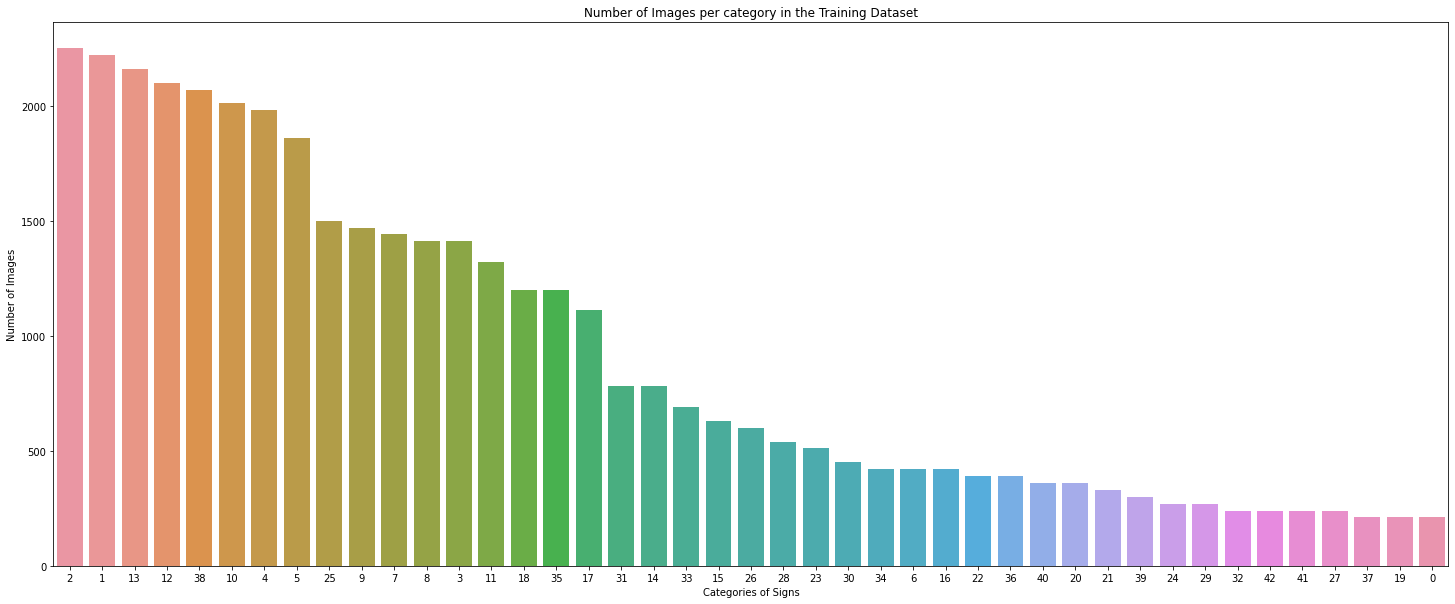

In [29]:
#plotting the number of samples in each class in train data
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((25,10))
sns.countplot(data = df_train, 
              x = 'ClassId',
              order = df_train['ClassId'].value_counts().index)
plt.xlabel('Categories of Signs')
plt.ylabel('Number of Images')
plt.title('Number of Images per category in the Training Dataset')
plt.savefig('/content/drive/MyDrive/Traffic_Sign_Recognition/train_images')
plt.show()

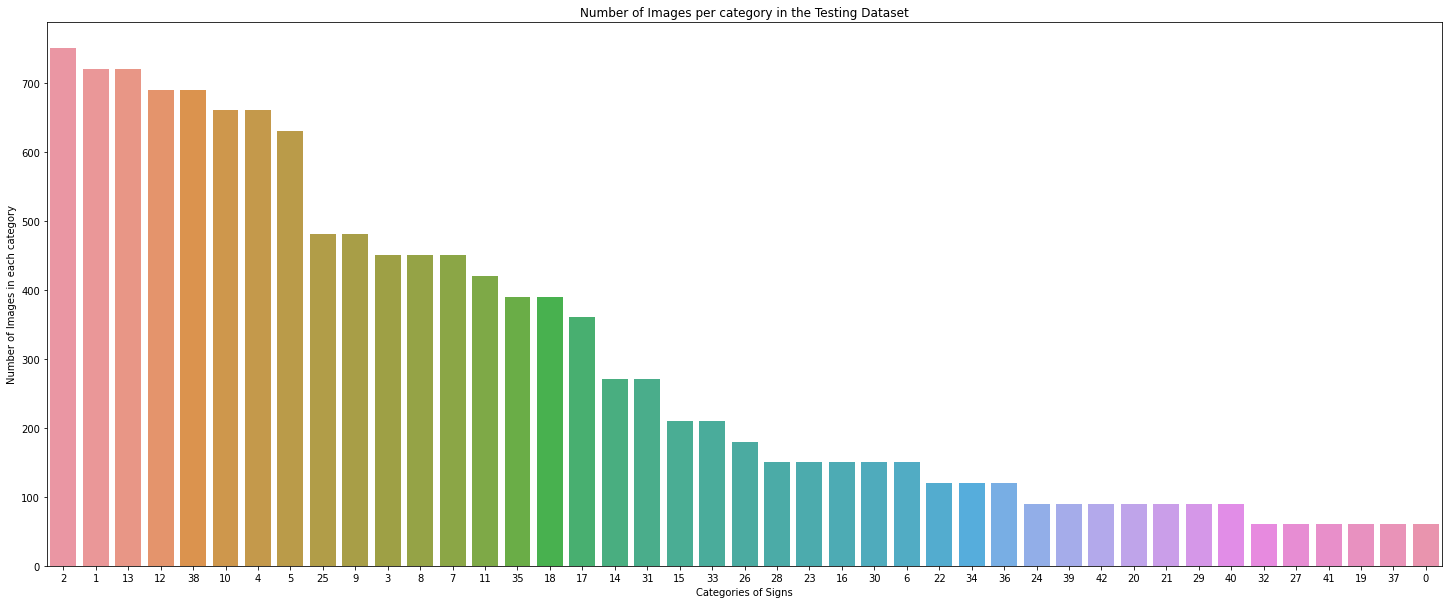

In [32]:
#plotting the number of samples in each class in test data
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((25,10))
sns.countplot(data =df_test, 
              x = 'ClassId',
              order = df_test['ClassId'].value_counts().index)
plt.xlabel('Categories of Signs')
plt.ylabel('Number of Images in each category')
plt.title('Number of Images per category in the Testing Dataset')
plt.savefig('/content/drive/MyDrive/Traffic_Sign_Recognition/test_images')
plt.show()

We see that some categories like 2,1,13,12,38,10, 4,5 are having much more training/test samples as compared to 0,19,37,27

It is possible, that the categories which having less images are not used commonly, so their data is less


In [114]:
ax[0][0]

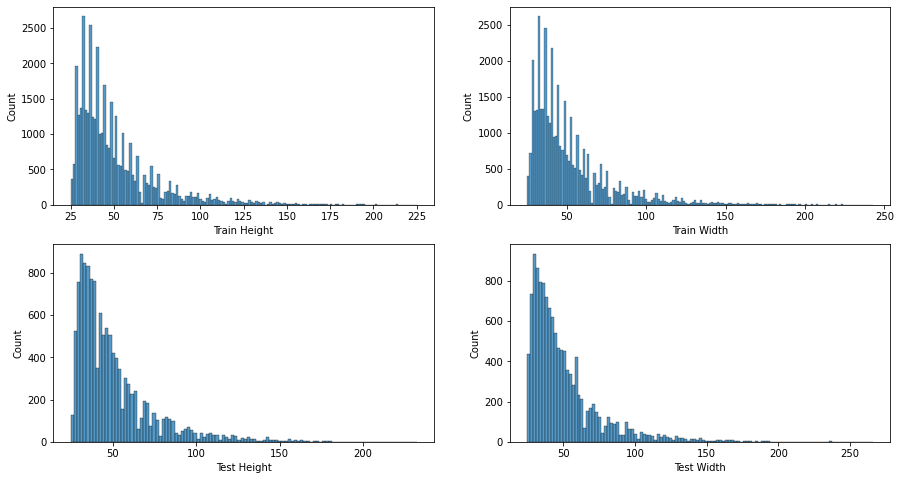

In [127]:
#Distplot for Height and Width of images in train data
fig, ax = plt.subplots(2, 2)
fig.set_size_inches((15,8))

sns.histplot(df_train['Height'], ax = ax[0][0])
ax[0][0].set_xlabel("Train Height")
sns.histplot(df_test['Height'], ax = ax[1][0])
ax[1][0].set_xlabel("Test Height")
sns.histplot(df_train['Width'], ax = ax[0][1])
ax[0][1].set_xlabel("Train Width")
sns.histplot(df_test['Width'], ax = ax[1][1])
ax[1][1].set_xlabel("Test Width")
plt.show()

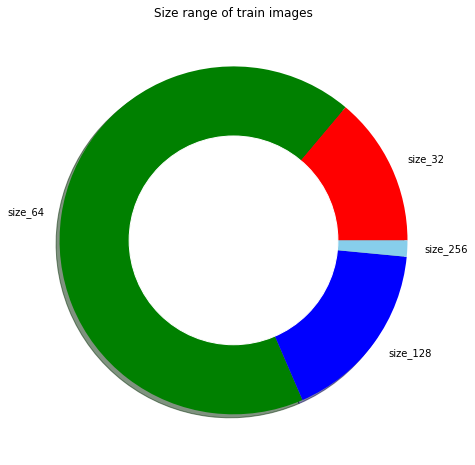

In [77]:
img_size_dict = {
    "size_32" : 0,
    "size_64" : 0,
    "size_128" : 0,
    "size_256" : 0,
    }
for index, row in df_train.iterrows():
  if (row[0] > 16 and row[1] > 16) and (row[0] < 32 and row[1] < 32) :
    img_size_dict['size_32'] += 1

  elif (row[0] > 32 and row[1] > 32) and (row[0] < 64 and row[1] < 64) :
    img_size_dict['size_64'] += 1

  elif (row[0] > 64 and row[1] > 64) and (row[0] < 128 and row[1] < 128) :
    img_size_dict['size_128'] += 1

  elif (row[0] > 128 and row[1] > 128) and (row[0] < 256 and row[1] < 256) :
    img_size_dict['size_256'] += 1
#print(img_size_dict)
categories = list(img_size_dict.keys())
sizes = list(img_size_dict.values())


my_circle=plt.Circle( (0,0), 0.6, color='white')
fig = plt.figure(figsize=(8,8))
plt.pie(sizes, labels=categories, colors=['red','green','blue','skyblue'], shadow=True)
plt.title("Size range of train images")
p=plt.gcf()
p.gca().add_artist(my_circle)
fig.show()

We see that the number of images having size greater than 128 are very less. So all the images lesser than 128 will be padded with same pixels as the boundary and those with sizes greater than 128 will be cropped

In [78]:
#Function to load each image with same dimensions
from tqdm import tqdm

## Function to padd the images which are smaller than 128 (width/height)
def padding(image) :
  top, bottom, left, right = 0, 0, 0, 0
  if image.shape[0] < 128 :
    diff = 128 - image.shape[0]
    top = math.ceil(diff/2)
    bottom = math.floor(diff/2)
  if image.shape[1] < 128 :
    diff = 128 - image.shape[1]
    left = math.ceil(diff/2)
    right = math.floor(diff/2)
  image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REPLICATE)
  return image

## Function to truncate the image with size greater than 128(width/height)
def truncate(image) :
  image = image[0:128, 0:128]
  return image

## Function to correct the size of all images to 128x128
def load_train_images_preprocessed() :

  n_classes = 43
  data = []
  labels = []

  #Reading the train images
  for itr in tqdm(range(n_classes)) :
    path = '/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Train/{0}/'.format(itr)
    Class = os.listdir(path)       # list of names of all files in a folder
    for c in Class :               # iterating over each image name  in that folder
      image = cv2.imread(path + c) # capturing the image 
      image = padding(image)       # padding if image is smaller
      image = truncate(image)      # cropping if image is bigger
      image = Image.fromarray(image, 'RGB')
      data.append(np.array(image))
      labels.append(itr)
  data=np.array(data)
  labels=np.array(labels)
  return data, labels

In [54]:
%%time
#Loading the preprocessed images(it takes 2:34 hours to process it. So the files have been saved and will be used in future)
# import random
# import math
# data_preprocessed, new_labels = load_train_images_preprocessed()
# np.save('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/data_preprocessed',data_preprocessed)
# np.save('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/labels',labels)


100%|██████████| 43/43 [2:33:58<00:00, 214.85s/it]


CPU times: user 1min 6s, sys: 21.6 s, total: 1min 28s
Wall time: 2h 34min 1s


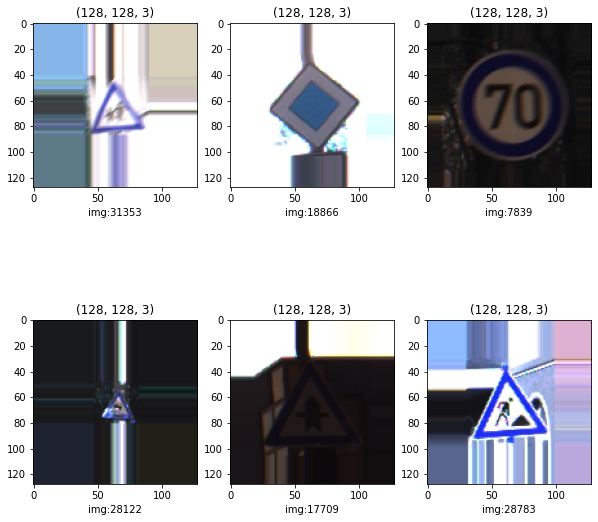

In [89]:
#randomly plotting the preprocessed images
fig, ax = plt.subplots(2,3)
height, width = 10, 10
for i in range(2):
  for j in range(3):

    fig.set_size_inches(height, width)
    seed = random.randrange(0, data_preprocessed.shape[0])
    ax[i][j].title.set_text(data_preprocessed[seed].shape)
    ax[i][j].imshow(data_preprocessed[seed])
    ax[i][j].set_xlabel("img:"+ str(seed))
    


We observe that someimages are too dark(17709) while some are too bright(28783), we need to correct this

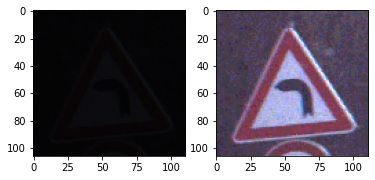

In [99]:
## enhancing the image to be able to see the content of the image from a dark image
from PIL import ImageEnhance, Image 

im = Image.open('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Train/19/00019_00004_00029.png')
enhancer = ImageEnhance.Brightness(im)
enhanced_im2 = enhancer.enhance(15)
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(enhanced_im2)
plt.show()